In [1]:
# load in the correct modules
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import tqdm
import hdbscan
from matplotlib import rc
# rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('font',**{'family':'serif','serif':['Times']})
rc('text', usetex=True)
import nmmn.plots
wolfram=nmmn.plots.wolframcmap() # for Mathematica's cmap
parula=nmmn.plots.parulacmap() # for MATLAB's cmap
turbo=nmmn.plots.turbocmap() # Turbo
import warnings
warnings.filterwarnings('ignore')


Bad key "text.kerning_factor" on line 4 in
/Users/qpasa/opt/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


# Load in the crossmatched APOGEE DR17 and planets catalogue (cross matched on the sky using a 5 arcsec cone)

In [5]:
# LOAD THE APOGEE DATA
path = '/Users/qpasa/Desktop/Master/data/planets_apogee.fits'
tb = fits.open(path)
data = tb[1].data 

In [7]:
lz = data['lz']*220*8.178
E = data['Energy']

# Cross match APOGEE DR17 with the planets file

(-1, 1)

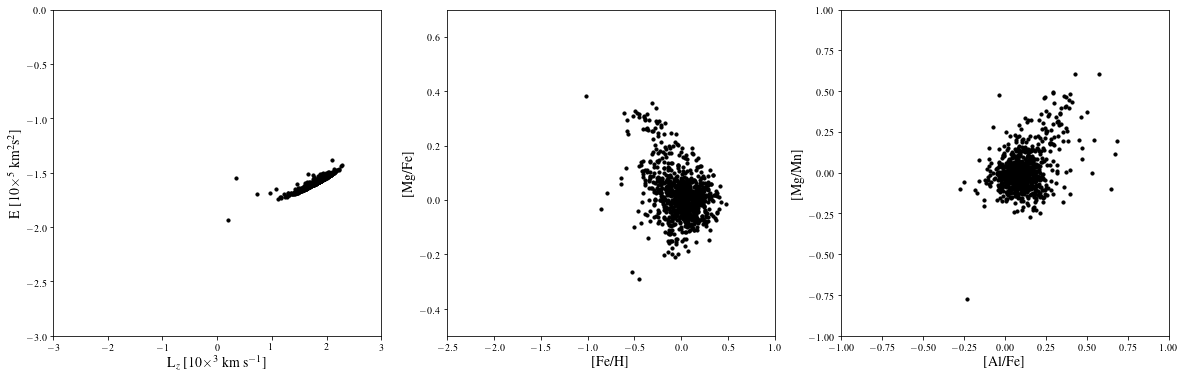

In [8]:
# check their E-Lz distribution and abundances

plt.figure(figsize=(20,6))

plt.subplot(1,3,1)
plt.scatter(lz/1e3,E/1e5,s=10,c='k')
plt.xlabel(r'L$_{z}$ [10$\times^{3}$ km s$^{-1}$]', fontsize=14)
plt.ylabel(r'E [10$\times^{5}$ km$^{2}$s$^{2}$]', fontsize=14)
plt.xlim(-3,3)
plt.ylim(-3,0)


plt.subplot(1,3,2)
plt.scatter(data['FE_H'],data['MG_FE'],s=10,c='k')
plt.xlabel(r'[Fe/H]', fontsize=14)
plt.ylabel(r'[Mg/Fe]', fontsize=14)
plt.xlim(-2.5,1)
plt.ylim(-0.5,0.7)

plt.subplot(1,3,3)
plt.scatter(data['AL_FE'],data['MG_FE']-data['MN_FE'],s=10,c='k')
plt.xlabel(r'[Al/Fe]', fontsize=14)
plt.ylabel(r'[Mg/Mn]', fontsize=14)
plt.xlim(-1,1)
plt.ylim(-1,1)

plt.subplots_adjust(hspace=0.2,wspace=0.4)




There is a star that has IoM like GES but has no abundances. The other stars with GES-like Mg-Fe are M-dwarfs with too cool Teff to get reliable abundances

In [13]:
mask_gesplanet = data['pl_name']=='K2-65 b'

print(data['MG_FE'][mask_gesplanet])
print(data['FE_H'][mask_gesplanet])
print(data['SNR'][mask_gesplanet])
print(data['TEFF'][mask_gesplanet])
print(data['LOGG'][mask_gesplanet])
print(data['weighted_dist'][mask_gesplanet]/1e3)
print(data['weighted_dist_error'][mask_gesplanet]/1e3)
print(data['APOGEE_ID'][mask_gesplanet])


[nan]
[nan]
[3.9906924]
[nan]
[nan]
[0.06296941]
[8.45134018e-05]
['2M22125079-1055311']


In [39]:
# This star is not in GALAH, RAVE, SEGUE

# Check the other kinematic planes

In [28]:
jr = data['jr']*220*8.178
jz = data['jz']*220*8.178
apo = data['rapo']*8.178
peri = data['rperi']*8.178
vx = data['vx']*220
vy = data['vy']*220
vz = data['vz_2']*220
vR = data['vR']*220
vphi = data['vT']*220
ecc = data['ecc']



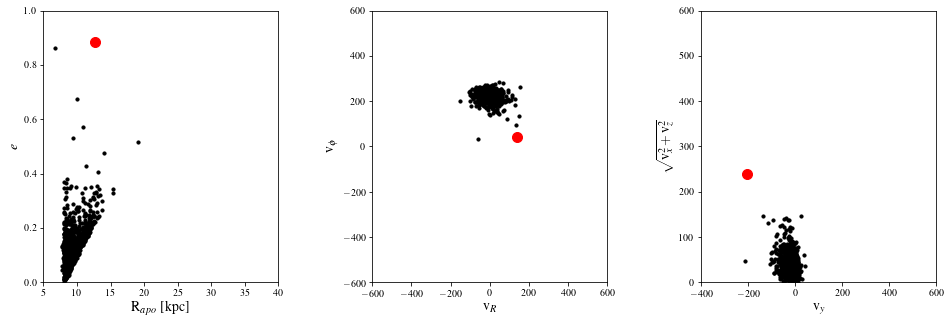

In [38]:
# check their E-Lz distribution and abundances

plt.figure(figsize=(16,5))

plt.subplot(1,3,1)
plt.scatter(apo,ecc,s=10,c='k')
plt.scatter(apo[mask_gesplanet],ecc[mask_gesplanet],s=100,c='r')
plt.xlabel(r'R$_{apo}$ [kpc]', fontsize=14)
plt.ylabel(r'$e$', fontsize=14)
plt.xlim(5,40)
plt.ylim(0,1)


plt.subplot(1,3,2)
plt.scatter(vR,vphi,s=10,c='k')
plt.scatter(vR[mask_gesplanet],vphi[mask_gesplanet],s=100,c='r')
plt.xlabel(r'v$_{R}$', fontsize=14)
plt.ylabel(r'v$_{\phi}$', fontsize=14)
plt.xlim(-600,600)
plt.ylim(-600,600)

plt.subplot(1,3,3)
plt.scatter(vy,np.sqrt(vx**2+vz**2),s=10,c='k')
plt.scatter(vy[mask_gesplanet],np.sqrt(vx**2+vz**2)[mask_gesplanet],s=100,c='r')
plt.xlabel(r'v$_{y}$', fontsize=14)
plt.ylabel(r'$\sqrt{\mathrm{v}_{x}^{2}+\mathrm{v}_{z}^{2}}$', fontsize=14)
plt.xlim(-400,600)
plt.ylim(0,600)

plt.subplots_adjust(hspace=0.2,wspace=0.4)





In [14]:
import galpy
from galpy.util import bovy_coords
from galpy.potential import IsochronePotential
from galpy.actionAngle import actionAngleIsochrone
# from galpy.potential import MWPotential2014
from galpy.actionAngle import actionAngleStaeckel
from galpy.actionAngle import estimateDeltaStaeckel
import tqdm
from galpy.orbit import Orbit
from galpy.potential.mwpotentials import McMillan17
from galpy.util.bovy_conversion import get_physical

# Let's re-run its orbits accounting for the uncertainties to see if its values are reliable

In [ ]:
ra = data['RA'][mask_gesplanet]
dec = data['DEC'][mask_gesplanet]
pmra = data['pmra'][mask_gesplanet]
pmdec = data['pmdec'][mask_gesplanet]
dist = data['weighted_dist'][mask_gesplanet]
rv = data['VHELIO_AVG'][mask_gesplanet]



In [ ]:
# create the covariance matrices

cov_gc = np.zeros([len(ra_gc),6,6])
cov_gc[:,0] = np.dstack([ra_err_gc**2, ra_err_gc*dec_err_gc*0., ra_err_gc*(dist_err_gc)*0.,\
                      ra_err_gc*pmra_err_gc*0., ra_err_gc*dec_err_gc*0., np.zeros(len(ra_gc))])[0]
cov_gc[:,1,1:] = np.dstack([dec_err_gc**2, dec_err_gc*(dist_err_gc)*0., dec_err_gc*pmra_err_gc*0.,\
                         dec_err_gc*pmdec_err_gc*0.,np.zeros(len(ra_gc))])[0]
cov_gc[:,2,2:] = np.dstack([(dist_err_gc)**2, (dist_err_gc)*pmra_err_gc*0., (dist_err_gc)*pmdec_err_gc*0.,\
                         np.zeros(len(ra_gc))])[0]
cov_gc[:,3,3:] = np.dstack([pmra_err_gc**2, pmra_err_gc*pmdec_err_gc*corr_coeff_gc, np.zeros(len(ra_gc))])[0]
cov_gc[:,4,4:] = np.dstack([pmdec_err_gc**2, np.zeros(len(ra_gc))])[0]
cov_gc[:,5,5] = vlos_err_gc**2
cov_gc[:,:,0] = cov_gc[:,0]
cov_gc[:,1:,1] = cov_gc[:,1,1:]
cov_gc[:,2:,2] = cov_gc[:,2,2:]
cov_gc[:,3:,3] = cov_gc[:,3,3:]
cov_gc[:,4:,4] = cov_gc[:,4,4:]

mean_gc = np.dstack([ra_gc,dec_gc,dist_gc,pmra_gc,pmdec_gc,vlos_gc])[0] 